In [1]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

project_root = Path.cwd().resolve().parent  # parent of notebooks/
sys.path.append(str(project_root))

from src.event_impact_modeling import EventImpactModeler

In [10]:
model = EventImpactModeler(
    data_path="../data/processed/ethiopia_fi_enriched_data.csv",
    impact_links_path="../data/processed/ethiopia_fi_impact_links.csv",
    ramp_months=6
)


2026-02-02 11:23:06,240 | INFO | Loaded 14 events, 32 observations, 5 impact links


In [11]:
summary = model.event_indicator_summary()
summary


,parent_id,indicator,category,event_date,pillar,related_indicator,impact_direction,impact_magnitude,lag_months,confidence
0,EVT_AGENT_REG,NaN,NaN,NaT,ACCESS,ACC_ACCOUNT_OWNERSHIP,increase,medium,12.0,medium
1,EVT_TELEBIRR,NaN,NaN,NaT,USAGE,ACC_MM_ACCOUNT,increase,high,6.0,high
2,EVT_TELEBIRR,NaN,NaN,NaT,USAGE,USG_DIGITAL_PAYMENT,increase,high,6.0,high
3,EVT_4G_EXPANSION,NaN,NaN,NaT,ACCESS,ACC_MOBILE_PEN,increase,medium,18.0,medium
4,EVT_FAYDA,NaN,NaN,NaT,ACCESS,ACC_ACCOUNT_OWNERSHIP,increase,medium,12.0,medium


In [12]:
assoc = model.build_association_matrix()
assoc


indicator,ACC_ACCOUNT_OWNERSHIP,ACC_MM_ACCOUNT,ACC_MOBILE_PEN,USG_DIGITAL_PAYMENT
event_id,,,,
EVT_4G_EXPANSION,0.0,0.0,1.5,0.0
EVT_AGENT_REG,1.5,0.0,0.0,0.0
EVT_FAYDA,1.5,0.0,0.0,0.0
EVT_TELEBIRR,0.0,3.0,0.0,3.0


Text(0.5, 1.0, 'Event–Indicator Association Matrix')

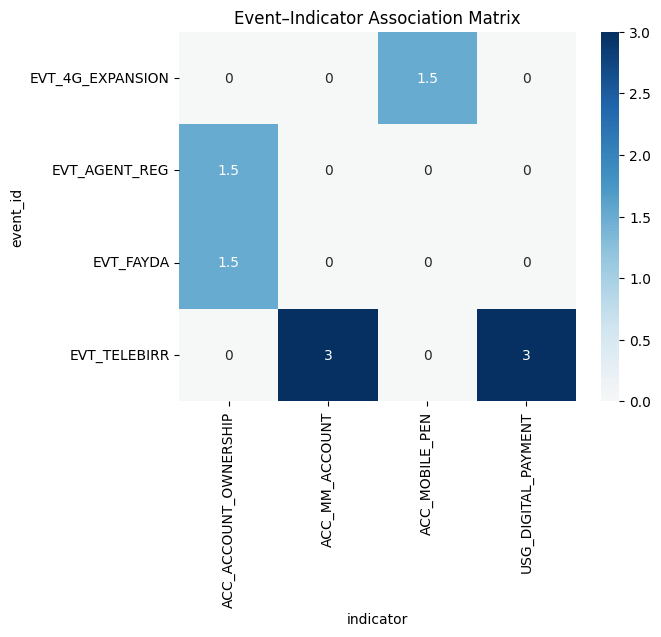

In [13]:
sns.heatmap(assoc, annot=True, cmap="RdBu", center=0)
plt.title("Event–Indicator Association Matrix")


In [14]:
telebirr_test = model.validate_against_actual("ACC_MM_ACCOUNT")
telebirr_test


,value_numeric,simulated,error_pp
observation_date,,,
2021-12-31,4.70,4.7,0.00
2024-11-29,9.45,4.7,-4.75


Text(0, 0.5, 'Percentage')

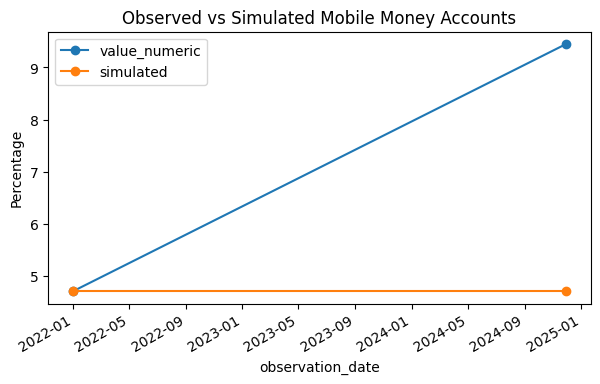

In [15]:
telebirr_test[["value_numeric", "simulated"]].plot(
    marker="o", figsize=(7,4)
)
plt.title("Observed vs Simulated Mobile Money Accounts")
plt.ylabel("Percentage")


2026-02-02 11:26:37,941 | WARNING | No observations found for ACC_ACCOUNT_OWNERSHIP


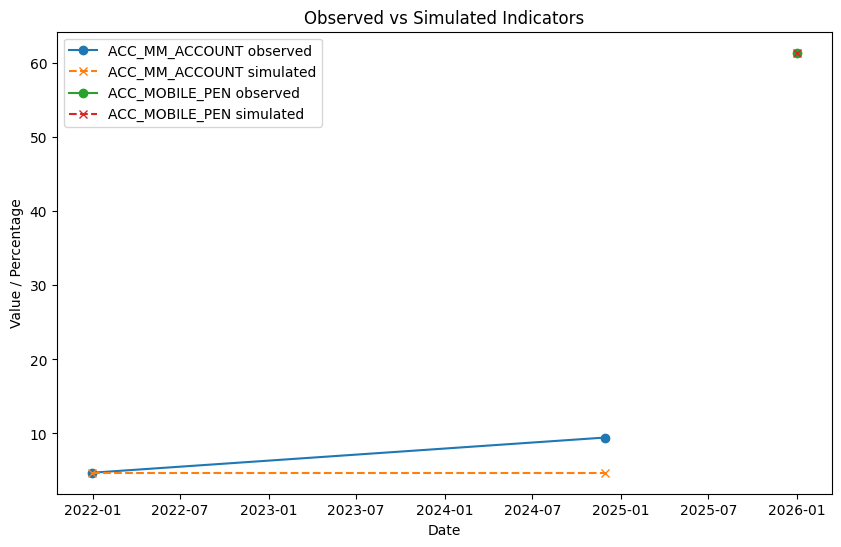

In [16]:
indicators = ["ACC_MM_ACCOUNT", "ACC_ACCOUNT_OWNERSHIP", "ACC_MOBILE_PEN"]
plt.figure(figsize=(10,6))

for ind in indicators:
    sim = model.validate_against_actual(ind)
    if sim is not None:
        plt.plot(sim.index, sim["value_numeric"], marker='o', label=f"{ind} observed")
        plt.plot(sim.index, sim["simulated"], marker='x', linestyle='--', label=f"{ind} simulated")

plt.legend()
plt.title("Observed vs Simulated Indicators")
plt.ylabel("Value / Percentage")
plt.xlabel("Date")
plt.show()


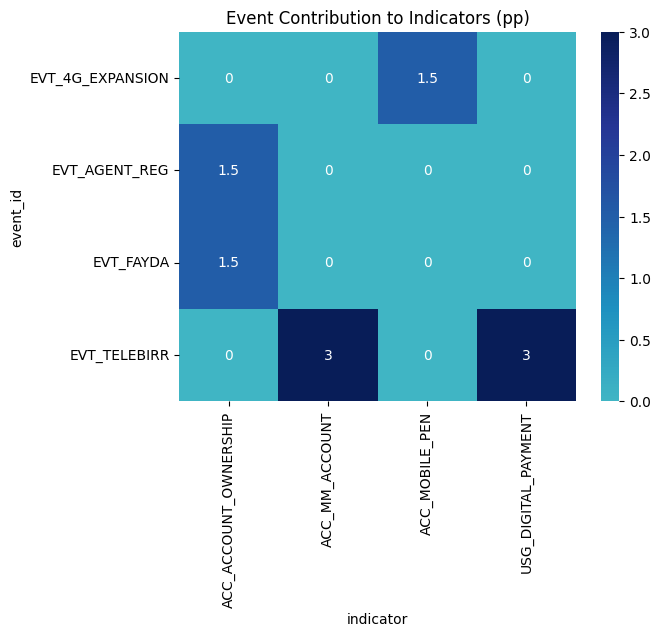

In [18]:
contrib_matrix = model.build_association_matrix()
sns.heatmap(contrib_matrix, annot=True, cmap="YlGnBu", center=0)
plt.title("Event Contribution to Indicators (pp)")
plt.show()


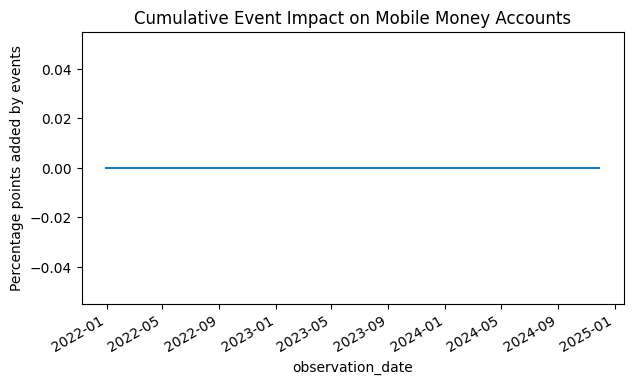

In [19]:
sim = model.simulate_indicator("ACC_MM_ACCOUNT")
sim["cumulative_effect"] = sim["simulated"] - sim["value_numeric"].iloc[0]
sim["cumulative_effect"].plot(figsize=(7,4))
plt.title("Cumulative Event Impact on Mobile Money Accounts")
plt.ylabel("Percentage points added by events")
plt.show()


# Summary & Methodology

## Project Overview
This project focuses on **Ethiopia's financial inclusion landscape** using historical data and enriched observations. The objective is to **model how key events, policies, and infrastructure developments influence financial inclusion indicators** over time, enabling better forecasting and policy evaluation.

## Data Sources
- **Global Findex (World Bank)**: Account ownership, mobile money, and other financial access indicators.
- **Ethio Telecom, EthSwitch, Safaricom Reports**: Digital payment and mobile money usage data.
- **Regulatory & Government Publications**: Policies, agent banking regulations, and digital ID (Fayda) rollout.
- **GSMA & ITU Reports**: Smartphone penetration and internet usage statistics.

## Methodology

### 1. Data Enrichment
- Observations and events were added to the historical dataset to **fill gaps and add high-frequency indicators**.
- Event metadata includes category, source, confidence, and notes for full provenance.
- **Impact links** were added to connect events with the indicators they influence, including:
  - `impact_direction` (increase/decrease)
  - `impact_magnitude` (low/medium/high)
  - `lag_months` to represent delayed effects

### 2. Event Impact Modeling
- An **EventImpactModeler** class simulates indicator evolution based on historical observations and the defined impact links.
- Steps include:
  1. **Event–Indicator Summary**: Merge events and impact links to identify affected indicators.
  2. **Association Matrix**: Create a matrix of events vs indicators with estimated effect sizes.
  3. **Simulation**: Apply lagged and ramped impact from events to simulate future indicator trajectories.
  4. **Validation**: Compare simulated paths with actual observed values for accuracy.

### 3. Ramp & Lag Assumptions
- Event effects are applied **gradually over a defined ramp period** (default 24 months, configurable).
- Lag for each event is applied using `lag_months` to account for **delayed impact** on indicators.

### 4. Logging & Reproducibility
- All data enrichment operations are logged with:
  - `record_id`, `record_type`, and provenance notes
- Outputs are **fully saved** in CSV format for:
  - Enriched dataset
  - Impact links
  - Data enrichment log

This methodology ensures **traceability, transparency, and consistent modeling** for financial inclusion analysis in Ethiopia.
